In [1]:
import os

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
import seaborn as sns
sns.set(font_scale=1.5, style="whitegrid")

Import necessary packages. Using seaborn to make a pretty plotting. Set font scale and style.

In [2]:
et.data.get_data("colorado-flood")

'/home/jovyan/earth-analytics/data/colorado-flood/.'

Get data and set working directory

In [3]:
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

Set working directory

In [4]:
dtm_path_pre = os.path.join("colorado-flood",
                        "spatial",
                        "boulder-leehill-rd",
                        "pre-flood",
                        "lidar",
                        "pre_DTM.tif")

dtm_path_post = os.path.join("colorado-flood",
                        "spatial",
                        "boulder-leehill-rd",
                        "post-flood",
                        "lidar",
                        "post_DTM.tif")

Define relative paths to DTM before flood. and defind a path to DTM files after flood. 
Telling python where to find the file.

In [5]:
pre_lidar_dtm = rxr.open_rasterio(dtm_path_pre, masked=True).squeeze()
post_lidar_dtm = rxr.open_rasterio(dtm_path_post, masked=True).squeeze()

Open DTM files befer and after flood,and mask no data values by reading in the data and using the masked=True parameter.

In [6]:
# Are the bounds the same?
print("Is the spatial extent the same?",
      post_lidar_dtm.rio.bounds() == pre_lidar_dtm.rio.bounds())

# Is the resolution the same ??
print("Is the resolution the same?",
      post_lidar_dtm.rio.resolution() == pre_lidar_dtm.rio.resolution())

Is the spatial extent the same? True
Is the resolution the same? True


Check DTM before and after flood cover the same spatial extent and are of the same spatial resolution (pixel size). 
the bounds and resolution are the same. This means it is safe to subtract the two rasters without significant errors or uncertainty introduced.

In [7]:
ter_lidar_dtm = post_lidar_dtm - pre_lidar_dtm
ter_lidar_dtm

<xarray.DataArray (y: 2000, x: 4000)>
array([[        nan,         nan,         nan, ..., -0.05004883,
         0.10998535,  0.09997559],
       [        nan,         nan,         nan, ...,  0.05993652,
        -0.01989746,  0.20996094],
       [        nan,         nan,         nan, ...,  0.14001465,
        -0.01000977,  0.11999512],
       ...,
       [        nan,         nan,         nan, ...,  1.42004395,
         1.41992188,  1.55993652],
       [        nan,         nan,         nan, ...,  0.67993164,
         0.97998047,  1.07006836],
       [        nan,         nan,         nan, ...,  0.29992676,
         0.4699707 ,  0.60998535]])
Coordinates:
    band         int64 1
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
    spatial_ref  int64 0

Calculate the difference of DTM between before and after flood. 

In [8]:
print('CHM min value:', np.nanmin(ter_lidar_dtm))
print('CHM max value:', np.nanmax(ter_lidar_dtm))

CHM min value: -19.6099853515625
CHM max value: 47.10009765625


Check minimum and maximum value of DTM before and after the flood.

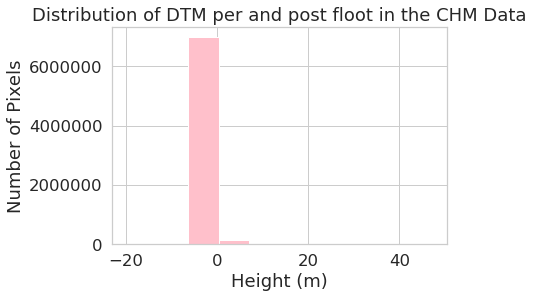

In [9]:
f, ax = plt.subplots()
ter_lidar_dtm.plot.hist(color="pink")
ax.set(title="Distribution of DTM per and post floot in the CHM Data",
       xlabel="Height (m)",
       ylabel="Number of Pixels")
plt.show()

Plot a histogram which quantifies the distribution of values of DTM before and after the flood.

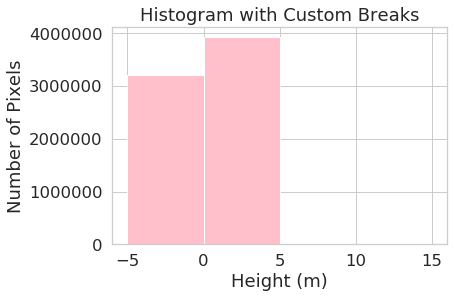

In [10]:
# Histogram with custom breaks
f, ax = plt.subplots()

ter_lidar_dtm.plot.hist(
    color='pink',
    bins=[-5, 0, 5, 10, 15])
ax.set(title="Histogram with Custom Breaks",
       xlabel="Height (m)",
       ylabel="Number of Pixels")

plt.show()

Based on min and max values, and histogram above, I customize the histogram with breaks between different bins.
Bins represents the edges. Positive and negative values are distributed around 0.

In [11]:
# Check nodata value for your array
ter_lidar_dtm.rio.nodata

Check nodata value for the array.

In [12]:
##Set our bins
class_bins = [-np.inf, 0, 5, 10, np.inf]
class_bins

[-inf, 0, 5, 10, inf]

Set bins. Any values that are equal to 15 or larger will be assigned a value of 5. 
Any values that are < -5 will be assigned a value of 0.

In [13]:
ter_lidar_dtm_class = xr.apply_ufunc(np.digitize,
                                     ter_lidar_dtm,
                                     class_bins)

Using the xarray library to apply numpy's digitize function. Creates a new object (ter_lidar_dtm_class) 
by applying digitize to our former object (ter_lidar_dtm) using the class_bins we designated above.

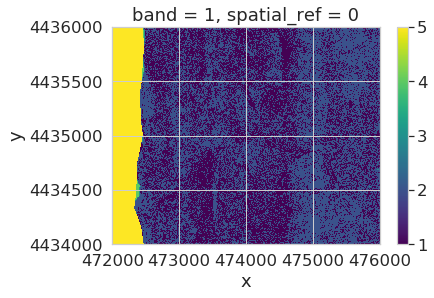

In [14]:
im = ter_lidar_dtm_class.plot.imshow()
ax.set_axis_off()

Using the plot.imshow() function to plot our raster as an image. 
Raster plot of I classified CHM. The yellow on the left side of the plot. 
Those pixels do not contain data and have been automatically classified as value = 5.

In [15]:
ter_lidar_dtm_class_ma = ter_lidar_dtm_class.where(ter_lidar_dtm_class != 5)
ter_lidar_dtm_class_ma

<xarray.DataArray (y: 2000, x: 4000)>
array([[nan, nan, nan, ...,  1.,  2.,  2.],
       [nan, nan, nan, ...,  2.,  1.,  2.],
       [nan, nan, nan, ...,  2.,  1.,  2.],
       ...,
       [nan, nan, nan, ...,  2.,  2.,  2.],
       [nan, nan, nan, ...,  2.,  2.,  2.],
       [nan, nan, nan, ...,  2.,  2.,  2.]])
Coordinates:
    band         int64 1
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
    spatial_ref  int64 0

Mask out values not equalt to 5.

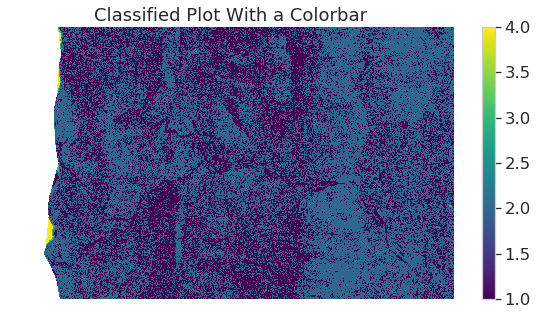

In [17]:
# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10,5))
ter_lidar_dtm_class_ma.plot.imshow()
ax.set(title="Classified Plot With a Colorbar")

ax.set_axis_off()
plt.show()

Plot newly classified and masked raster. DTM before and after flood plot with NA values applied to the data.

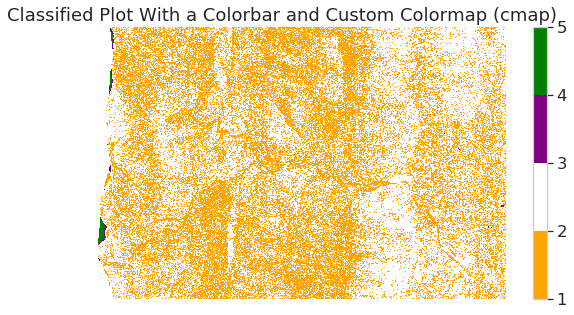

In [19]:
# Plot data using nicer colors
colors = ['orange', 'white', 'purple', 'green']
class_bins = [1, 2, 3, 4, 5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, 
                    len(colors))

# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10, 5))
ter_lidar_dtm_class_ma.plot.imshow(cmap=cmap,
                                   norm=norm)
ax.set(title="Classified Plot With a Colorbar and Custom Colormap (cmap)")
ax.set_axis_off()
plt.show()

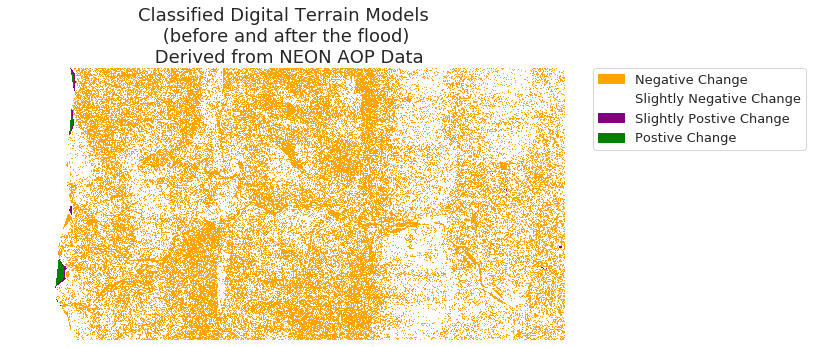

In [20]:
# Create a list of labels to use for your legend
height_class_labels = ["Negative Change",
                       "Slightly Negative Change",
                       "Slightly Postive Change",
                       "Postive Change"]

# Create a colormap from a list of colors
colors = ['orange', 'white', 'purple', 'green']

cmap = ListedColormap(colors)

class_bins = [1, 2, 3, 4, 5]
norm = BoundaryNorm(class_bins,
                    len(colors))

# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10, 5))
im = ter_lidar_dtm_class_ma.plot.imshow(cmap=cmap,
                                        norm=norm,
                                        # Turn off colorbar
                                        add_colorbar=False)
# Add legend using earthpy
ep.draw_legend(im,
               titles=height_class_labels)
ax.set(title="Classified Digital Terrain Models \n (before and after the flood) \n Derived from NEON AOP Data")
ax.set_axis_off()
plt.show()

In [ ]:
Add title and legends. I use different colors to highlight the difference between DTM before and after flood. 
Add a legend that clearly shows what each color in my classified raster represents.